sử dụng dữ liệu bike-sharing-dataset: và sử dụng mô hình direct multi-step time series. Em sử dụng mô hình linear regression 
và sử dụng pipepline và grid search
 em dùng 4 giờ liên tục để dự đoán giờ tiếp theo, tiếp theo +2, và tiếp theo +3 

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lazypredict.Supervised import LazyRegressor

In [230]:
df = pd.read_csv('bike-sharing-dataset.csv')

In [231]:
df.head()

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
0,2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
1,2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2,2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5
3,2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0,13.0,1,3,5
4,2011-01-01 04:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0,1.0,1,4,5


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_time   17544 non-null  object 
 1   holiday     17544 non-null  float64
 2   workingday  17544 non-null  float64
 3   weather     17544 non-null  object 
 4   temp        17544 non-null  float64
 5   atemp       17544 non-null  float64
 6   hum         17544 non-null  float64
 7   windspeed   17544 non-null  float64
 8   users       17544 non-null  float64
 9   month       17544 non-null  int64  
 10  hour        17544 non-null  int64  
 11  weekday     17544 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 1.6+ MB


In [233]:
df['date_time'] = pd.to_datetime(df['date_time'])


In [234]:
df.head()

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
0,2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
1,2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2,2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5
3,2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0,13.0,1,3,5
4,2011-01-01 04:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0,1.0,1,4,5


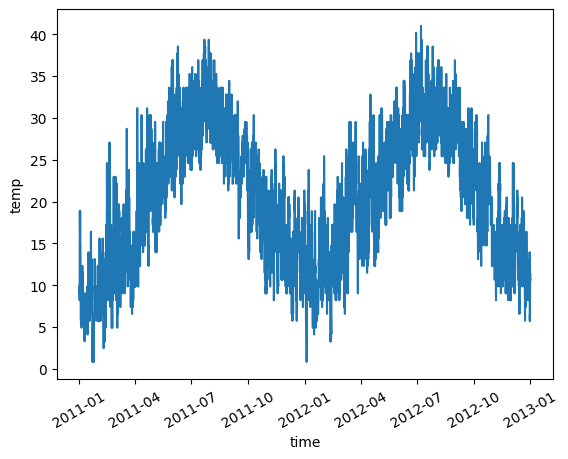

In [235]:
plt.plot(df.date_time, df.temp)
plt.xlabel('time')
plt.ylabel("temp")
plt.xticks(rotation = 30)
plt.show()

### create data

In [236]:
def create_data(data, window_size, target_size):
    i = 1
    while i < window_size:
        data['temp_{}'.format(i)] = data['temp'].shift(-i)
        i +=1
    i = 0
    while i < target_size:
        data['target_{}'.format(i)] = data['temp'].shift(-i-window_size)
        i += 1
    data = data.dropna(axis = 0)
    return data


In [237]:
window_size = 5
target = 3
df = create_data(df,window_size,target)

In [238]:
target = ["target_{}".format(i) for i in range(target)]
x = df.drop(['date_time'] + target, axis = 1)
y =df[target]

In [239]:
ratio = 0.8
x_train = x[ : int(len(x)*ratio)]
y_train = y[ : int(len(y)*ratio)]

x_test = x[int(len(x)*ratio) : ]
y_test = y[int(len(y)*ratio) : ]

In [240]:
num_feature = Pipeline(steps=[
    ("standard_scale", StandardScaler())
])

weather_values = df['weather'].unique()
ord_feature = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[weather_values]))
])


In [241]:
preprocessor = ColumnTransformer(transformers=[
    ("num_feature", num_feature, ['holiday', 'workingday','temp', 'atemp','hum','windspeed','users','month', 'hour','weekday','temp_1','temp_2','temp_3']),
    ("ord_feature", ord_feature,['weather'] )
])

In [242]:
reg1 = Pipeline(steps=[
    ('preprocess1', preprocessor),
    ("model1",LinearRegression())
])

In [243]:
reg2 = Pipeline(steps=[
    ("preprocess2", preprocessor),
    ("model2", SVR())
])

In [244]:
reg3 = Pipeline(steps=[
    ("preprocess3", preprocessor),
    ("model3", GradientBoostingRegressor())
])

In [245]:
regs = [reg1, reg2, reg3]

In [175]:

for i, reg in enumerate(regs):
    reg.fit(x_train, y_train["target_{}".format(i)])
    

In [141]:
r2 = []
mse = []
mae = []
pred = []

In [142]:
for i, reg in enumerate(regs):
    y_pred = reg.predict(x_test)
    pred.append(y_pred)
    r2.append(r2_score(y_test['target_{}'.format(i)], y_pred))
    mse.append(mean_squared_error(y_test['target_{}'.format(i)], y_pred))
    mae.append(mean_absolute_error(y_test['target_{}'.format(i)], y_pred))

In [143]:
r2

[0.969486595554271, 0.9605059827049185, 0.9582310616682153]

In [144]:
mae

[0.8886072978416536, 1.0167516242763224, 1.0374666213547246]

In [145]:
mse

[1.4652779237096836, 1.8960992082928272, 2.004854892158523]

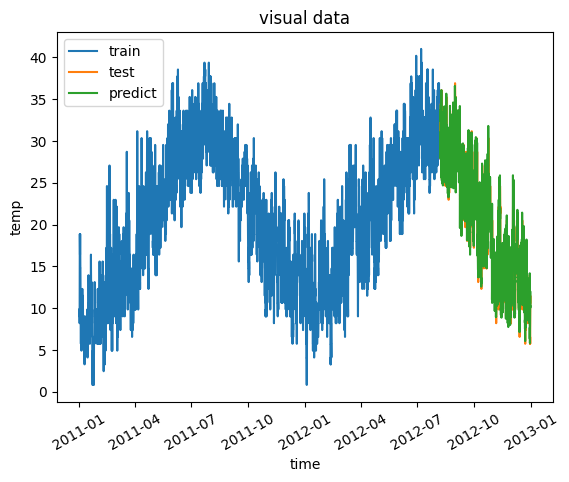

In [146]:
plt.plot(df['date_time'][:int(len(df)*0.8)], df['temp'][:int(len(df)*0.8)], label = "train")
plt.plot(df['date_time'][int(len(df)*0.8):], df['temp'][int(len(df)*0.8):], label = "test")
plt.plot(df['date_time'][int(len(df)*0.8):], pred[0], label = "predict")
plt.xlabel("time")
plt.ylabel("temp")
plt.title("visual data")
plt.xticks(rotation = 30)
plt.legend()
plt.show()

In [246]:
pram1 = {
    "model1__fit_intercept" : [True, False],
    "model1__copy_X" : [True, False],
}

In [247]:
pram2 = {
    "model2__degree" : [5,7],
    "model2__gamma" : ['scale',"auto"]
}

In [248]:
pram3 = {
    "model3__learning_rate" : [0.1,0.01],
    "model3__n_estimators" : [50,100,150]
}

In [249]:
prams = [pram1, pram2, pram3]
grid_model = []

In [250]:
for i, reg in enumerate(regs):
    grid_pred = GridSearchCV(reg, param_grid=prams[i], n_jobs= -1, verbose= 1, scoring='r2', cv= 6)
    grid_model.append(grid_pred.fit(x_train, y_train["target_{}".format(i)]))

    

Fitting 6 folds for each of 4 candidates, totalling 24 fits
Fitting 6 folds for each of 4 candidates, totalling 24 fits
Fitting 6 folds for each of 6 candidates, totalling 36 fits


In [258]:
print(grid_model[2].best_score_)

0.8899063375067073


In [257]:
print(grid_model[2].best_params_)

{'model3__learning_rate': 0.1, 'model3__n_estimators': 150}


In [259]:
pred_lazy = LazyRegressor(verbose= 0, ignore_warnings= False, custom_metric= None)
models, predictions = pred_lazy.fit(x_train, x_test, y_train['target_0'], y_test['target_0'])

 69%|██████▉   | 29/42 [01:30<00:31,  2.44s/it]